In [2]:
import pandas as pd
import numpy as np
import json
import trimesh
import matplotlib.pyplot as plt
import pyglet
from pyglet.gl import *
import pyvista as pv
from mpl_toolkits.mplot3d import Axes3D
import ast
from sklearn.cluster import KMeans
from itertools import cycle

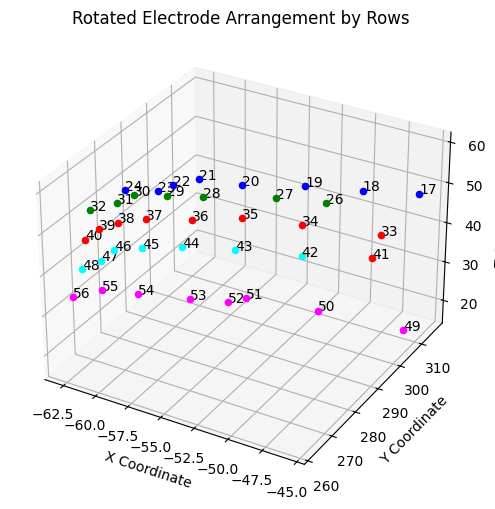

In [4]:
# ep129 roi 2

# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

def rotation_matrix_x(theta):
    cos_theta, sin_theta = np.cos(np.radians(theta)), np.sin(np.radians(theta))
    return np.array([[1, 0, 0],
                     [0, cos_theta, -sin_theta],
                     [0, sin_theta, cos_theta]])
# Filter electrodes based on ROI and get their positions
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 2]
for item in electrode_roi_2_df["electrodes"].iloc[0]:  # Assuming electrode numbers are in the first row
    if item in electrode_position_map:
        # print(electrode_position_map[item], '?????')
        roi2_arr.append(electrode_position_map[item])


# Rotate the positions
theta = 18
positions = np.array(roi2_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 2
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]
    
rows_electrode_numbers.append(current_row_electrode_numbers)

# Save the rows of electrode numbers to a JSON file
with open('roi2_electrodes.json', 'w') as f:
    json.dump(rows_electrode_numbers, f)

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        

# ax.view_init(elev=0, azim=180)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()
